## This notebook uses a modified version of Millar et al 2021's R code for automatic event delineation and hysteresis calcs using the s::can and discharge data from [Kincaid et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027361) 

- ### Data publicly available here on HydroShare: https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/

- ### This larger dataset includes the 2014-2015 discharge and nitrate data from Vaughan, M. (2017). Vermont NEWRnet stations: 2014-2015 high-frequency DOC, nitrate, and discharge data, HydroShare, http://www.hydroshare.org/resource/faac1672244c407e9c9c8644c8211fd6.

- ### Note that there is a Hungerford data gap in 2016 to adjust this code for

- ### I downloaded on 05.02.24 and put it here in this directory /home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_partition_hysteresis

- ### The raw data file has discharge (q m3s), NO3, and SRP with timestamp and event start/end times for each watershed. The Millar code takes just timestamp, q, and C input csvs so I separate this raw data file into just those parameters for each site over the entire time period (>400 events from 2014 to 2018, no winter events).

### TO DO

- [x] use Kincaid 2020 FC, SFT, # of bf and sf passes, and min event duration
- [x] dynamic min_duration b/c Kincaid 2020 values differ per site
- [ ] figure out what's wrong with the HI calc
        - See bottom cell for old, working version (verified 2024-08-06)

In [1]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)

###################
# SET DIRECTORIES #
###################

# Define the input and output directories

# For Kincaid data, input and output in separate directory
input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare"
output_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare/output"

# functions script in main millar directory
millar_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/"

#####################
# READ IN FUNCTIONS #
#####################

# MED note: I haven't altered anything in this functions script
source(file.path(input_dir,"cQ_functions.R"))

#################
# SET SITE INFO #
#################

# Set site name
Site = "Wade"

# Set year or other time if doing yearly
Year = "2014-2018"

# Set constituent
Analyte = "NO3"

# Set catchment area based on Site
if (Site == "Hungerford") {
  Area <- 48.1
} else if (Site == "Potash") {
  Area <- 18.4
} else if (Site == "Wade") {
  Area <- 16.7
} else {
  Area <- NA  # or any default value if Site is not one of the specified values
}

# Set minimum event duration (hrs) area based on Site
# values from Kincaid et al 2020 SI Table 2
if (Site == "Hungerford") {
  min_dur <- 6
} else if (Site == "Potash") {
  min_dur <- 4
} else if (Site == "Wade") {
  min_dur <- 4
} else {
  min_dur <- NA  # or any default value if Site is not one of the specified values
}

# Specify constituent in data set name
dataSetName = paste(Site,"_",Analyte,"_",Year, sep="")

# Chose constitution for plot axes labels (NO3, TOC, or turbidity)
constit <- Analyte

##########################
# SET RDF and SEP PARAMS #
##########################

# Set stormflow thresholds in cms
# In this case, based on Kincaid values above in table. Can use a range in other cases (see cell below).
if (Site == "Hungerford") {
  candidateSfThresh <- 0.1
} else if (Site == "Potash") {
  candidateSfThresh <- 0.12
} else if (Site == "Wade") {
  candidateSfThresh <- 0.05
} else {
  candidateSfThresh <- NA  # or any default value if Site is not one of the specified values
}

# Vector containing candidate baseflow separation filter values
#candidateFilterPara <- c(0.996,0.98)
candidateFilterPara <- c(0.996) # what Kincaid 2020 used for the 15 min data

# Vector with interpolation intervals used for calculating HI
interp <- seq(0,1,0.01)

# Print the Area and SFT to check
print(paste('Site = ', Site))
print(paste('catchment area (km2) = ', Area))
print(paste('stormflow threshold (cms) = ', candidateSfThresh))
print(paste('minimum event duration (hrs) = ', min_dur))

#########################
# READ IN AND TIDY DATA #
#########################

# Read in raw Hydroshare data csv from Kincaid et al 2020 found at https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/
# Downloaded on 05.02.24
allInputData15Min <- read.csv(file.path(input_dir,"hydroshare_rawData.csv"))

# Rename the 'timestamp' column to 'datetime' to conform with Millar script
names(allInputData15Min)[names(allInputData15Min) == "timestamp"] <- "datetime"

# Filter the data for just the site and for the year/time range you want
# Memory issues if you try to process all the Kincaid 2014-2018 data at once, sometimes
# Remove rows with missing values
Site_input <- allInputData15Min %>%
  #filter(site == Site & year(datetime) == Year) %>%
  filter(site == Site) %>%
  drop_na(q_cms, NO3_mgNL) %>%
  select(datetime, q_cms, conc = NO3_mgNL)

Site_input$datetime <- as.POSIXct(Site_input$datetime,format("%Y-%m-%d %H:%M:%S"),tz="EST")

# Rescale the data
Site_input <- Site_input %>% 
  mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms)))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



[1] "Site =  Wade"
[1] "catchment area (km2) =  16.7"
[1] "stormflow threshold (cms) =  0.05"
[1] "minimum event duration (hrs) =  4"


### Now, running the Millar code to get separate baseflow, smooth stormflow, delineate events, and calculate flusing and hysteresis indices

In [3]:
##########################################
# RUN ANALYSIS TO GET HYSTERESIS INDICES #
##########################################

batchRun1 <- batchRunBfAndEvSepForCQ(qInputs = Site_input,
                                     bfSepPasses = 3, # orig 3
                                     filterParam = candidateFilterPara,
                                     sfSmoothPasses = 4, # orig 4
                                     sfThresh = candidateSfThresh,
                                     cInputs = Site_input,
                                     timeStep = 15,
                                     minDuration = min_dur,# min duration from Kincaid 2020 SI Table 2
                                     maxDuration = 200)

eventsDataAll1 <- getAllStormEvents(batchRun = batchRun1,
                                    timestep_min = 15)

batchRunFlowsLF1 <- batchRunflowCompare(qData = Site_input,
                                         bfSepPasses = 4, # orig 4
                                         filterPara = candidateFilterPara,
                                         sfSmoothPasses = 4) # orig 4

eventsData1 <- stormEventCalcs(batchRun = batchRun1,
                               timestep_min = 15)

stormCounts1 <- stormCounts(batchRun1)

hysteresisData1 <- getHysteresisIndices(batchRun = batchRun1,
                                        xForInterp = interp,
                                        eventsData = eventsData1)


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

ERROR: Error in approx(qNormRising, cNormRising, xout = xForInterp): need at least two non-NA values to interpolate


### Export the results

In [4]:
######################
# EXPORT OUTPUT DATA #
######################

write.csv(eventsData1,file = file.path(output_dir,paste(dataSetName,"_StormEventSummaryData.csv",sep="")))
write.csv(batchRunFlowsLF1,file = file.path(output_dir,paste(dataSetName,"_DischargeData.csv",sep="")))
#write.csv(hysteresisData1,file = file.path(output_dir,paste(dataSetName,"_HysteresisData.csv",sep="")))
write.csv(eventsDataAll1,file = file.path(output_dir,paste(dataSetName,"_AllCQData.csv",sep="")))
write.csv(stormCounts1,file = file.path(output_dir,paste(dataSetName,"_StormCounts.csv",sep="")))

### Plot and save event delineation data

In [5]:
#########################################
# PLOT AND SAVE DATA - EVENT SEPARATION #
#########################################

# Make subfolder in output directory to save hydrograph plots
dir.create(file.path(output_dir, "Hydrographs"), showWarnings = FALSE)

# 1) Plot and save the hydrograph with input data
# MED note that for the Kincaid data I had to change 'timestamp' to 'datetime'when reading in the csv

initialHydrograph <- ggplot(Site_input,aes(x=datetime, y=q_cms)) +
                            geom_line(size=0.5, color="black") +
                            xlab(NULL) +
                            ylab(expression(paste("Total discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_TotalDischarge.jpeg")),
       initialHydrograph,
       width = 12, 
       height = 4, 
       units = "in",
       dpi=600)


# 2) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=total_flow), size=0.5, color="black") +
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=base_flow,color=filter_para), linewidth=0.75) +
                            scale_color_brewer(palette = "Set1") +
                            xlab(NULL) +
                            ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(legend.title = element_blank(),
                                  text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3) Plot smoothed storm flows

stormflowHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), linewidth=0.75) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3a) Plot smoothed storm flows with storm flow thresholds

stormflowThreshHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), linewidth=0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = candidateSfThresh, linetype = "dashed", color = "black",alpha=0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 4) Plot batch run event separation hydrographs
eventsDataShaded1 <- eventsData1 %>% mutate(start = as.POSIXct(start,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            end = as.POSIXct(end,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            tops = max(Site_input$q_cms),
                                            bottoms = 0)

batchEventSepPlot <- ggplot() + 
  geom_rect(data=eventsDataShaded1, mapping=aes(xmin=start, 
                                                xmax=end, 
                                                ymin=bottoms, 
                                                ymax=tops), fill="green", color="red", alpha=0.2) +
  
  geom_line(data=Site_input, aes(x=datetime, y=q_cms), size=0.8, color="blue") +
  geom_line(data=Site_input, aes(x=datetime, y=rescaled_conc), linewidth=0.5, color="black",linetype="dashed") +
  facet_wrap(~ run_id, ncol = 1) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
  scale_x_datetime(limits = as.POSIXct(c("2018-04-01 00:00:00", "2018-11-01 01:00:00"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))


ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot.jpeg")),
       batchEventSepPlot,
       width = 18, 
       height = 5, 
       units = "in",
       dpi=600)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 151 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 68231 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 68231 rows containing missing values (`geom_line()`).”


Warning message:
“Removed 151 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 68231 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 68231 rows containing missing values (`geom_line()`).”


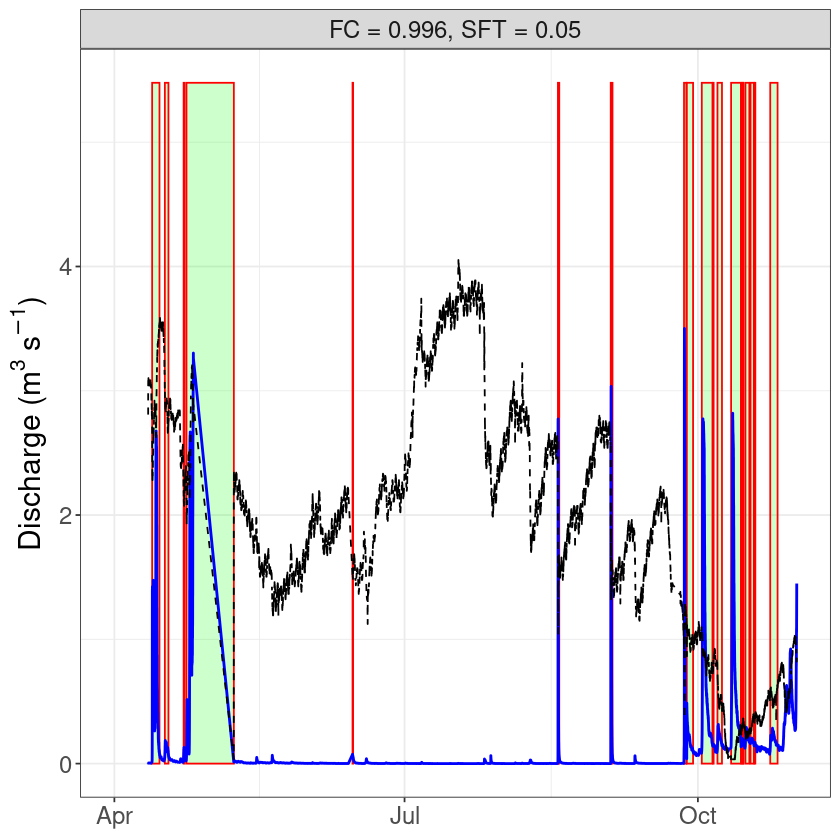

In [6]:
batchEventSepPlot

### Plotting and saving cQ output

In [ ]:
####################################
# PLOT AND SAVE DATA - c-Q RESULTS #
####################################

if (constit == "NO3") {
  
  makeCQPlotsNO3(batchRun1)
  makeHystFlushPlotsNO3(hysteresisData1)
  
} else if (constit == "TOC") {

makeCQPlotsTOC(batchRun1)
makeHystFlushPlotsTOC(hysteresisData1)
  
} else if (constit == "turbity") {
    
makeCQPlotsTurb(batchRun1) 
makeHystFlushPlotsTurb(hysteresisData1)
  
}

## OLD WORKING FOR HI

In [ ]:
# Main script to separate baseflow, delineate storm events, 
# and run c-Q hysteresis index analyses

# Clear memory
rm(list=ls())


#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)

###################
# SET DIRECTORIES #
###################

# Define the input and output directories

# For Kincaid data, input and output in separate directory
input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare"
output_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare/output"

# functions script in main millar directory
millar_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/"

#####################
# READ IN FUNCTIONS #
#####################

# MED note: I haven't altered anything in this functions script
source(file.path(input_dir,"cQ_functions.R"))

################
# READ IN DATA #
################

# Read in raw Hydroshare data csv from Kincaid et al 2020 found at https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/
# Downloaded on 05.02.24

allInputData15Min <- read.csv(file.path(input_dir,"hydroshare_rawData.csv"))

# Rename the 'timestamp' column to 'datetime' to conform with Millar script
names(allInputData15Min)[names(allInputData15Min) == "timestamp"] <- "datetime"

# Filter the data for just Hungerford Brook for the year/time range you want
# Memory issues if you try to process all the Kincaid 2014-2018 data at once
# Remove rows with missing values
Hford <- allInputData15Min %>%
  filter(site == "Hungerford" & year(datetime) == 2015) %>%
  drop_na(q_cms, NO3_mgNL) %>%
  select(datetime, q_cms, conc = NO3_mgNL)

# Specify constituent in data set name
dataSetName <- "HF_NO3"

# Chose constitution for plot axes labels (NO3, TOC, or turbidity)
constit <- "NO3"

Hford$datetime <- as.POSIXct(Hford$datetime,format("%Y-%m-%d %H:%M:%S"),tz="EST")

# Rescale the data
Site_input <- Hford %>% 
  mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms)))

# Vector containing candidate baseflow separation filter values
candidateFilterPara <- c(0.996,0.98)

# Vector containing candidate stormflow threshold values
candidateSfThresh <- c(0.098,0.1,0.12) # MED HF guess values; Kincaid et al 2020 used 0,1

# Vector with interpolation intervals used for calculating HI
interp <- seq(0,1,0.01)

In [ ]:
##########################################
# RUN ANALYSIS TO GET HYSTERESIS INDICES #
##########################################

batchRun1 <- batchRunBfAndEvSepForCQ(qInputs = Site_input,
                                     bfSepPasses = 3, # orig 3
                                     filterParam = candidateFilterPara,
                                     sfSmoothPasses = 4, # orig 4
                                     sfThresh = candidateSfThresh,
                                     cInputs = Site_input,
                                     timeStep = 15,
                                     minDuration = 6, #min_dur,# min duration from Kincaid 2020 SI Table 2
                                     maxDuration = 200)

eventsDataAll1 <- getAllStormEvents(batchRun = batchRun1,
                                    timestep_min = 15)

batchRunFlowsLF1 <- batchRunflowCompare(qData = Site_input,
                                         bfSepPasses = 4, # orig 4
                                         filterPara = candidateFilterPara,
                                         sfSmoothPasses = 4) # orig 4

eventsData1 <- stormEventCalcs(batchRun = batchRun1,
                               timestep_min = 15)

stormCounts1 <- stormCounts(batchRun1)

hysteresisData1 <- getHysteresisIndices(batchRun = batchRun1,
                                        xForInterp = interp,
                                        eventsData = eventsData1)
